# OCR Project for Debit Cards and National ID Cards

## Imports

In [1]:
import tensorflow as tf 
from tensorflow.keras import layers, models, losses, regularizers, optimizers, applications, callbacks, utils
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

import cv2

from PIL import Image, ImageDraw, ImageFont

import numpy as np

import matplotlib.pyplot as plt

import os

import random

import time

## Constants

In [2]:
input_shape = (200, 320, 3)

num_poolings = 6
window_size = input_shape[0]//2**num_poolings, input_shape[1]//2**num_poolings

convert_bboxes_to_relative_bboxes = True

num_anchors = 4 # 10
num_classes = 10

batch_size = 128
lr = 1e-3
reg_coef = 5e-5
dropout_rate = 0.4
class_weights_obj = 1. # float(window_size[0] * window_size[1])

threshold_conf = 0.5
# threshold_nms = 0.5

num_generating = 400_000
generating_index = 0

num_generating_credit = num_generating // 2
num_generating_ID = num_generating // 2
num_generating_en = num_generating_credit // 2

runtime_id = time.asctime().replace(":", "-")

log_dir = "./logs/" + runtime_id
monitor_metric = "val_bboxes_mae"

model_name = "sliding_window_ocr_model"
model_path = "./models/" + model_name + "_" + runtime_id + ".h5"
model_plot_path = "./models/plots/" + model_name + "_" + runtime_id + ".png"

template_path = "./templates"

dataset_path = "./dataset"
trainset_path = "./dataset/trainset"
testset_path = "./dataset/testset"

nums_en = list("0123456789")
nums_per = list("۰۱۲۳۴۵۶۷۸۹")

## Utility Functions

In [3]:
def read_img(img_path):
    img = utils.load_img(img_path, target_size=input_shape[:2])
    img = utils.img_to_array(img).astype("uint8")

    return img

In [4]:
def read_annotation(annot_path):
    with open(annot_path, 'r') as file:
        lines = file.read().split('\n')

    info = lines[0].split(' ')
    card_type, cvv2, exp_date = int(info[0]), int(info[1]), int(info[2])
    
    classes = []
    bboxes = []
    for line in lines[1:-1]:
        numbers = line.split(' ')
        class_id, *box = numbers
        
        classes.append(int(class_id))
        bboxes.append([int(coord) for coord in box])

    return classes, bboxes, card_type, cvv2, exp_date

In [5]:
def add_bbox_on_img(img, bboxes, labels=None):
    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox
        img = cv2.rectangle(img.copy(), (x, y), (x + w, y + h), (255, 0, 0), 0)

        if labels is not None:
            text_position = (x + int(w / 2) - 5, y - 1)    
            img = cv2.putText(img.copy(), str(labels[i]), text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 0)
    
    return img

In [6]:
def show_img(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [7]:
def show_annotated_img(img_path, annot_path):
    classes, bboxes, card_type, cvv2, exp_date = read_annotation(annot_path)
    
    img = read_img(img_path)
    
    img = add_bbox_on_img(img, bboxes, labels=classes)
    
    show_img(img)

In [8]:
def detect_and_crop_card(image_path):
    pass

In [49]:
def predict(img):
    results = model.predict(img[None])

    # card_type = results["card_type"][0]
    # cvv2 = int(results["cvv2"][0][0] * 1e4)
    # exp_date = int(results["exp_date"][0][0] * 1e8)

    found_conf, found_bboxes, found_classes = [], [], []
    for i in range(window_size[0]):
        for j in range(window_size[1]):
            for k in range(num_anchors):
                conf = results[f"confs_anchor_{k}"][0][i, j, 0]
                if conf >= threshold_conf:
                    cls = results[f"classes_anchor_{k}"][0][i, j]
                    bbox = results[f"bboxes_anchor_{k}"][0][i, j]

                    if convert_bboxes_to_relative_bboxes:
                        denormed_bbox = convert_relative_bbox_to_bbox(bbox, window=(j, i))
                    else:
                        denormed_bbox = (int(bbox[0]*input_shape[1]), int(bbox[1]*input_shape[0]), \
                            int(bbox[2]*input_shape[1]), int(bbox[3]*input_shape[0]))

                    found_conf.append(float(f'{conf:.2f}'))
                    found_bboxes.append(denormed_bbox)
                    found_classes.append(cls.argmax(axis=-1))

    return found_conf, found_bboxes, found_classes, _, _, _ #, card_type, cvv2, exp_date

In [10]:
def predict_and_show(img_path, crop=False):
    if crop:
        img = detect_and_crop_card(img_path)
    else:
        img = read_img(img_path)

    found_conf, found_bboxes, found_classes, card_type, cvv2, exp_date = predict(img)

    print(f"Confidence Scores: {found_conf}")
    print(f"Found Classes: {found_classes}")
    print(f"Found Objects #: {len(found_bboxes)}")
    print()
    print(f"Card Type: {card_type}")
    print(f"CVV2: {cvv2}")
    print(f"Expiration Date: {exp_date}")

    img = add_bbox_on_img(img, found_bboxes, found_classes)
    show_img(img)

## Generating Synthesized Dataset

In [11]:
utils.set_random_seed(42)

In [12]:
def generate_fake_card(template_path, template_type, info, index):
    card_template = utils.load_img(template_path, target_size=input_shape[:2])
    draw = ImageDraw.Draw(card_template)

    font_color = (0, 0, 0)

    if template_type == 0:
        card_number, cvv2, exp_date = info 

        font_type = ["arial.ttf", "calibri.ttf", "times.ttf"]
        random.shuffle(font_type)
        
        card_number_font_size = random.randint(30, 40)
        exp_date_font_size = random.randint(10, 20)
            
        card_number_font = ImageFont.truetype(font_type[0], card_number_font_size)
        exp_date_font = ImageFont.truetype(font_type[0], exp_date_font_size)
    
        card_number_position = (random.randint(0, 30), random.randint(90, 150))
        cvv2_position = (random.randint(10, 300), random.randint(10, 230))
        exp_date_position = (random.randint(0, 300), random.randint(200, 230))
    
        bboxes = []
        nums = []
        for char in card_number:
            draw.text(card_number_position, char, font=card_number_font, fill=font_color)
            
            x, y = card_number_position
            w, h = card_number_font.getbbox(char)[2:]
            
            card_number_position = (x+w, y)
            if char != ' ':
                bboxes.append((x, y, w, h))
                nums.append(int(char))
        
        draw.text(cvv2_position, cvv2, font=exp_date_font, fill=font_color)
        draw.text(exp_date_position, exp_date, font=exp_date_font, fill=font_color)

    elif template_type == 1:
        ID, name, lname, b_date, fname, exp_date = info 
                    
        font = ImageFont.truetype("calibri.ttf", 14)
    
        ID_position = (230, 67)
        name_position = (255, 92)
        lname_position = (240, 118)
        b_date_position = (230, 140)
        fname_position = (255, 167)
        exp_date_position = (230, 190)
    
        bboxes = []
        nums = []
        for char in ID:
            draw.text(ID_position, char, font=font, fill=font_color)
            x, y = ID_position
            w, h = font.getbbox(char)[2:]
            ID_position = (x+w, y)

            bboxes.append((x, y, w, h))
            nums.append(int(char))
        
        draw.text(name_position, name, font=font, fill=font_color)
        draw.text(lname_position, lname, font=font, fill=font_color)
        draw.text(b_date_position, b_date, font=font, fill=font_color)
        draw.text(fname_position, fname, font=font, fill=font_color)
        draw.text(exp_date_position, exp_date, font=font, fill=font_color)

    card_template.save(os.path.join(trainset_path, "images", f"{index}.png"), "PNG")
    with open(os.path.join(trainset_path, "annotations", f"{index}.txt"), 'w') as file:
        if template_type == 0:
            cvv2 = cvv2.replace('CVV2: ', '')
            exp_date = exp_date.replace('/', '').replace('انقضا: ', '')
            if cvv2[-1] in nums_per:
                cvv2 = "".join([nums_en[nums_per.index(num)] for num in cvv2])
                exp_date = "".join([nums_en[nums_per.index(num)] for num in exp_date])
            file.write(f"{template_type} {cvv2} {exp_date}\n")
        elif template_type == 1:
            exp_date = "".join([nums_en[nums_per.index(num)] for num in exp_date.replace('/', '')])
            file.write(f"{template_type} 0 {exp_date}\n")

        for box, num in zip(bboxes, nums):
            if num in nums_per:
                num = nums_en[nums_per.index(num)]
            file.write(f"{num} {box[0]} {box[1]} {box[2]} {box[3]}\n")

In [13]:
def generate_fake_credit_info(lang="english"):
    if lang == "english":
        chars = nums_en.copy()
    elif lang == "persian":
        chars = nums_per.copy()

    space = random.randint(1, 3)

    card_number = ""
    for i in range(16):
        if i % 4 == 0:
            card_number += ' ' * space
        random.shuffle(chars)
        card_number += str(chars[0])

    cvv2 = "CVV2: "
    for i in range(4):
        random.shuffle(chars)
        cvv2 += str(chars[0])

    exp_date = "انقضا: "
    for i in range(4):
        if i == 2:
            exp_date += '/'
        random.shuffle(chars)
        exp_date += str(chars[0])
    
    return card_number.lstrip(), cvv2, exp_date

In [14]:
def generate_fake_ID_info():
    nums = nums_per.copy()
    chars = list("صثقفعهخحجچپمنالبیسشطزردوکگءغضئآذژظ")
    
    ID = ""
    for _ in range(10):
        random.shuffle(nums)
        ID += str(nums[0])

    name = ""
    for _ in range(random.randint(3, 10)):
        random.shuffle(chars)
        name += str(chars[0])

    lname = ""
    for _ in range(random.randint(4, 15)):
        random.shuffle(chars)
        lname += str(chars[0])

    b_date = ""
    for i in range(8):
        if i in (4, 6):
            b_date += '/'
        random.shuffle(nums)
        b_date += str(nums[0])

    fname = ""
    for _ in range(random.randint(3, 10)):
        random.shuffle(chars)
        fname += str(chars[0])

    exp_date = ""
    for i in range(8):
        if i in (4, 6):
            exp_date += '/'
        random.shuffle(nums)
        exp_date += str(nums[0])
    
    return ID, name, lname, b_date, fname, exp_date

In [15]:
templates_type0 = os.listdir(template_path+"/credit")
templates_type1 = os.listdir(template_path+"/national ID")

num_generating_en_each_temp = num_generating_en // len(templates_type0)

templates_type0, templates_type1

(['ayandeh_1.jpg',
  'ayandeh_2.jpg',
  'dey_1.jpg',
  'dey_2.jpg',
  'ghavamin_1.jpg',
  'keshavarzi_1.jpg',
  'keshavarzi_2.jpg',
  'keshavarzi_3.jpg',
  'keshavarzi_4.jpg',
  'keshavarzi_5.jpg',
  'meli_1.jpg',
  'meli_2.jpg',
  'meli_3.jpg',
  'refah_1.jpg',
  'saderat_1.jpg',
  'saderat_2.jpg',
  'saderat_3.jpg',
  'saderat_4.jpg',
  'saderat_5.jpg',
  'saman_1.jpg',
  'sepah_1.jpg',
  'shahr_1.jpg',
  'sina_1.jpg',
  'sina_2.jpg',
  'tejarat_1.jpg',
  'tejarat_2.jpg'],
 ['aa.jpg'])

In [16]:
# for temp_path in templates_type0:
#     temp_full_path = os.path.join(template_path, "credit", temp_path)
#     for _ in range(num_generating_en_each_temp):
#         print(f"\rGenerating new english-numbered, credit-card image({generating_index}) from {temp_path}", end="")

#         info = generate_fake_credit_info(lang="english")
        
#         generate_fake_card(
#             temp_full_path, 
#             template_type=0, 
#             info=info,
#             index=generating_index
#         )
        
#         generating_index += 1

In [17]:
# for temp_path in templates_type0:
#     temp_full_path = os.path.join(template_path, "credit", temp_path)
#     for _ in range(num_generating_en_each_temp):
#         print(f"\rGenerating new persian-numbered, credit-card image({generating_index}) from {temp_path}", end="")

#         info = generate_fake_credit_info(lang="persian")
        
#         generate_fake_card(
#             temp_full_path, 
#             template_type=0, 
#             info=info,
#             index=generating_index
#         )
        
#         generating_index += 1

In [18]:
# for temp_path in templates_type1:
#     temp_full_path = os.path.join(template_path, "national ID", temp_path)
#     for _ in range(num_generating_ID):
#         print(f"\rGenerating new national-ID image({generating_index}) from {temp_path}", end="")

#         info = generate_fake_ID_info()
        
#         generate_fake_card(
#             temp_full_path, 
#             template_type=1, 
#             info=info,
#             index=generating_index
#         )
        
#         generating_index += 1

In [19]:
trainset_images = os.listdir(os.path.join(trainset_path, "images"))
trainset_annotations = os.listdir(os.path.join(trainset_path, "annotations"))

len(trainset_images), len(trainset_annotations)

(199992, 199992)

### Showing randomly chosen generated images

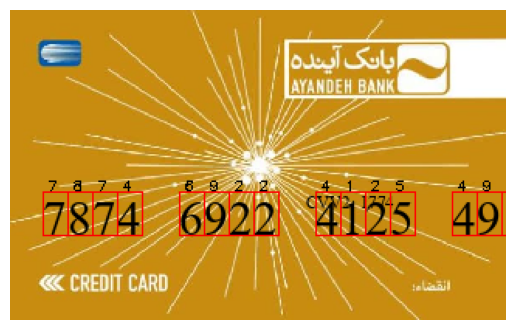

In [20]:
show_annotated_img(os.path.join(trainset_path, "images", trainset_images[0]), os.path.join(trainset_path, "annotations", trainset_annotations[0]))

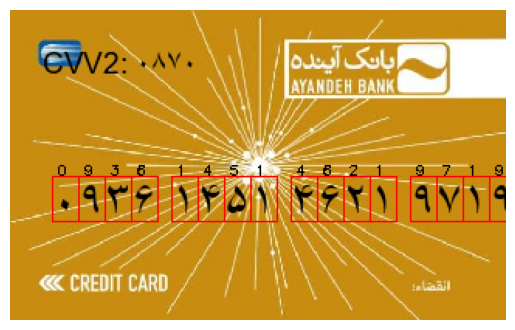

In [21]:
show_annotated_img(os.path.join(trainset_path, "images", trainset_images[2484]), os.path.join(trainset_path, "annotations", trainset_annotations[2484]))

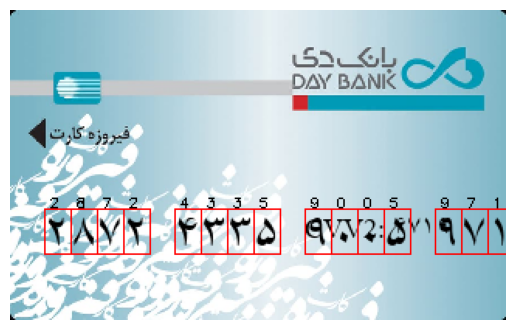

In [22]:
show_annotated_img(os.path.join(trainset_path, "images", trainset_images[9963]), os.path.join(trainset_path, "annotations", trainset_annotations[9963]))

## Preparing the Dataset

In [23]:
x_train, x_val, y_train, y_val = train_test_split(trainset_images, trainset_annotations, test_size=0.15, shuffle=True, random_state=42)
len(x_train), len(x_val)

(169993, 29999)

In [24]:
def IoU(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    w_intersection = min(x1 + w1, x2 + w2) - x_intersection
    h_intersection = min(y1 + h1, y2 + h2) - y_intersection
    
    if w_intersection <= 0 or h_intersection <= 0:
        return 0.0
    
    intersection_area = w_intersection * h_intersection
    
    area_box1 = w1 * h1
    area_box2 = w2 * h2
    
    union_area = area_box1 + area_box2 - intersection_area
    
    iou_score = intersection_area / union_area

    return iou_score

In [25]:
def calculate_corresponding_window(bbox):
    x_center = bbox[0] + bbox[2] / 2
    y_center = bbox[1] + bbox[3] / 2

    grid_x = int(x_center / (input_shape[1] / window_size[1]))
    grid_y = int(y_center / (input_shape[0] / window_size[0]))

    return grid_x, grid_y

In [26]:
def calculate_corresponding_anchor(bbox, window):
    grid_x, grid_y = window

    window_length = (input_shape[1] / window_size[1])
    window_height = (input_shape[0] / window_size[0])

    window_start_x = window_length * grid_x
    window_start_y = window_height * grid_y

    window_anchors = []
    for anchor in range(num_anchors):
        y = int(window_start_y)
        w = int(window_length / num_anchors)
        h = int(window_height)
        x = int(window_start_x + w * anchor)
        window_anchors.append((x, y, w, h))

    anchors_iou = []
    anchors_idx = []
    for i, anchor in enumerate(window_anchors):
        iou_score = IoU(bbox, anchor)
        anchors_iou.append(iou_score)
        anchors_idx.append(i)

    anchors_iou_and_idx = zip(anchors_iou, anchors_idx)
    anchors_sorted_iou_and_idx = sorted(anchors_iou_and_idx, key=lambda x: x[0], reverse=True)
    anchors_sorted_iou = [idx for _, idx in anchors_sorted_iou_and_idx]

    return anchors_sorted_iou

In [27]:
def convert_bbox_to_relative_bbox(bbox):
    x, y, w, h = bbox
    grid_x, grid_y = calculate_corresponding_window(bbox)

    window_length = (input_shape[1] / window_size[1])
    window_height = (input_shape[0] / window_size[0])

    window_start_x = window_length * grid_x
    window_start_y = window_height * grid_y

    window_x = (x - window_start_x) / window_length
    window_y = (y - window_start_y) / window_height

    window_w = w / window_length
    window_h = h / window_height

    bbox = (window_x, window_y, window_w, window_h)

    return bbox

In [28]:
def convert_relative_bbox_to_bbox(bbox, window):
    window_x, window_y, window_w, window_h = bbox
    grid_x, grid_y = window

    window_length = (input_shape[1] / window_size[1])
    window_height = (input_shape[0] / window_size[0])

    window_start_x = window_length * grid_x
    window_start_y = window_height * grid_y

    x = int(window_start_x + window_x * window_length)
    y = int(window_start_y + window_y * window_height)

    w = int(window_w * window_length)
    h = int(window_h * window_height)

    bbox = (x, y, w, h)

    return bbox

In [29]:
def create_annotation_lists(annotation_paths):
    confs_list = []
    bboxes_list  = []
    all_classes_list = []
    card_types_list  = []
    infos_list  = []
    
    for i, annot_path in enumerate(annotation_paths):
        print(f"\rAnnotation file#: {i}", end="")

        classes, bboxes, card_type, *info = read_annotation(os.path.join(trainset_path, "annotations", annot_path))
        card_types_list.append(np.array(card_type, dtype="uint8")[None])
        infos_list.append(info)
    
        confs = np.zeros((*window_size, 1*num_anchors), dtype="float32")
        normed_windowed_bboxes = {f"bboxes_anchor_{i}": np.zeros((*window_size, 4), dtype="float32") for i in range(num_anchors)}
        classes_dict = {f"classes_anchor_{i}": np.zeros(window_size, dtype="float32") for i in range(num_anchors)}
        for bbox, cls in zip(bboxes, classes):
            grid_x, grid_y = calculate_corresponding_window(bbox)
            if grid_x >= window_size[1] or grid_y >= window_size[0]:
                continue

            if convert_bboxes_to_relative_bboxes:
                normed_bbox = convert_bbox_to_relative_bbox(bbox)
            else:
                normed_bbox = (bbox[0]/input_shape[1], bbox[1]/input_shape[0], bbox[2]/input_shape[1], bbox[3]/input_shape[0])

            anchor_iou_sorted = calculate_corresponding_anchor(bbox, (grid_x, grid_y))
            for anchor_i in anchor_iou_sorted:
                if (normed_windowed_bboxes[f"bboxes_anchor_{anchor_i}"][grid_y, grid_x] == 0).all():
                    normed_windowed_bboxes[f"bboxes_anchor_{anchor_i}"][grid_y, grid_x] = normed_bbox
                    break

            confs[grid_y, grid_x, anchor_i] = 1
            classes_dict[f"classes_anchor_{anchor_i}"][grid_y, grid_x] = cls

        classes_list = [classes_dict[key] for key in classes_dict.keys()]
        normed_windowed_bboxes_list = [normed_windowed_bboxes[key] for key in normed_windowed_bboxes.keys()]
    
        confs_list.append(confs)
        bboxes_list.append(normed_windowed_bboxes_list)
        all_classes_list.append(classes_list)

    print()

    return confs_list, bboxes_list, all_classes_list, card_types_list, infos_list

In [30]:
train_confs, train_bboxes, train_classes, train_card_types, train_infos = create_annotation_lists(y_train)
val_confs, val_bboxes, val_classes, val_card_types, val_infos = create_annotation_lists(y_val)

Annotation file#: 169992
Annotation file#: 29998


In [31]:
def preprocess_img_annot(img_path, confs, classes_list, bboxes, card_type, info):   
    x = tf.io.read_file(trainset_path+"/images/"+img_path)
    x = tf.image.decode_image(x)

    cvv2, exp_date = info[0], info[1]

    y = {
        **{f"confs_anchor_{i}": confs[..., i, None] for i in range(num_anchors)}, 
        **{f"bboxes_anchor_{i}": bboxes[i] for i in range(len(bboxes))}, 
        **{f"classes_anchor_{i}": classes_list[i] for i in range(len(classes_list))}, 
        # "card_type": card_type, 
        # "cvv2": tf.cast(cvv2, dtype=tf.float32)/1e4, 
        # "exp_date": tf.cast(exp_date, dtype=tf.float32)/1e8,
    }
    
    return x, y

In [32]:
trainset = tf.data.Dataset.from_tensor_slices((x_train, train_confs, train_classes, train_bboxes, train_card_types, train_infos))
trainset = trainset.map(preprocess_img_annot, num_parallel_calls=4)
trainset = trainset.shuffle(1_000).batch(batch_size).prefetch(4)

valset = tf.data.Dataset.from_tensor_slices((x_val, val_confs, val_classes, val_bboxes, val_card_types, val_infos))
valset = valset.map(preprocess_img_annot, num_parallel_calls=4)
valset = valset.batch(batch_size).prefetch(4)

## Creating the Model

In [33]:
class OCRModel(models.Model):

    def train_step(self, data):
        inputs, targets = data

        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            if not self.compiled_loss.built:
                self.compiled_loss.build(predictions)
            
            total_loss = self.losses
            for output_name, loss_fn_name in self.loss.items():
                loss_fn = losses.get(loss_fn_name)

                if "bboxes_anchor_" in output_name:
                    anchor_index = int(output_name[-1])
                    masks = tf.tile(targets[f"confs_anchor_{anchor_index}"][..., None], [1, 1, 1, 4])
                    loss = loss_fn(targets[output_name], predictions[output_name] * masks)
                    loss *= masks[..., 0] * class_weights_obj
                elif "classes_anchor_" in output_name:
                    anchor_index = int(output_name[-1])
                    masks = tf.tile(targets[f"confs_anchor_{anchor_index}"][..., None], [1, 1, 1, num_classes])
                    loss = loss_fn(targets[output_name], predictions[output_name] * masks)
                    loss *= masks[..., 0] * class_weights_obj
                else:
                    loss = loss_fn(targets[output_name], predictions[output_name])

                loss *= self.compiled_loss._user_loss_weights[output_name]
                loss = tf.reduce_mean(loss)
                self.compiled_loss.metrics[list(self.loss.keys()).index(output_name)+1].update_state(loss)
                total_loss += loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.compiled_loss.metrics[0].update_state(total_loss)
        self.compiled_metrics.update_state(targets, predictions)
        metrics_dict = {m.name: m.result() for m in self.metrics}

        return metrics_dict

In [34]:
def create_sliding_window_ocr_model():
    conv_base = applications.Xception(include_top=False, input_shape=input_shape)
    for layer in conv_base.layers[:-10]:
        layer.trainable = False

    input_image = layers.Input(shape=input_shape, dtype=tf.uint8, name="image")
    x = layers.Lambda(lambda X: applications.xception.preprocess_input(\
        tf.cast(X, dtype=tf.float32)), name="xception_preprocess")(input_image)
    x = conv_base(x)


    # z = layers.GlobalAveragePooling2D()(x)

    # z = layers.Dense(1024, activation="relu", name="bottleneck_dense_1")(z)
    # z = layers.Dropout(dropout_rate, name="bottleneck_do_1")(z)

    # z = layers.Dense(512, activation="relu", name="bottleneck_dense_2")(z)
    # z = layers.Dropout(dropout_rate, name="bottleneck_do_2")(z)

    # card_type = layers.Dense(1, activation="sigmoid", name="card_type")(z)
    # cvv2 = layers.Dense(1, activation="linear", name="cvv2")(z)
    # exp_date = layers.Dense(1, activation="linear", name="exp_date")(z)


    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)

    x1 = layers.SeparableConv2D(512, kernel_size=1, padding="same", use_bias=False, name="bboxes_anchors_bottleneck_conv_1")(x)
    x1 = layers.BatchNormalization(name="bboxes_anchors_bottleneck_bn_1")(x1)
    x1 = layers.ReLU(name="bboxes_anchors_bottleneck_relu_1")(x1)

    x1 = layers.SeparableConv2D(256, kernel_size=1, padding="same", use_bias=False, name="bboxes_anchors_bottleneck_conv_2")(x1)
    x1 = layers.BatchNormalization(name="bboxes_anchors_bottleneck_bn_2")(x1)
    x1 = layers.ReLU(name="bboxes_anchors_bottleneck_relu_2")(x1) 

    confs_outputs = [layers.SeparableConv2D(1, kernel_size=1, padding="same", activation="sigmoid", name=f"confs_anchor_{i}")(x) for i in range(num_anchors)] 
    bboxes_outputs = [layers.SeparableConv2D(4, kernel_size=1, padding="same", activation="linear", name=f"bboxes_anchor_{i}")(x1) for i in range(num_anchors)]
    classes_outputs = [layers.SeparableConv2D(num_classes, kernel_size=1, padding="same", activation="softmax", name=f"classes_anchor_{i}")(x) for i in range(num_anchors)]


    model = models.Model(
        inputs=input_image, 
        outputs={
            **{f"confs_anchor_{i}": confs_outputs[i] for i in range(num_anchors)}, 
            **{f"bboxes_anchor_{i}": bboxes_outputs[i] for i in range(num_anchors)},
            **{f"classes_anchor_{i}": classes_outputs[i] for i in range(num_anchors)},
            # "card_type": card_type,
            # "cvv2": cvv2,
            # "exp_date": exp_date
        }, 
        name=model_name
    )

    return model

In [35]:
def func():
    model1 = models.load_model("./models/sliding_window_ocr_model_Tue Feb 20 10-06-07 2024.h5")

    model.get_layer("xception").set_weights(model1.get_layer("xception").get_weights())

    model.get_layer("bboxes_anchors_bottleneck_conv_1").set_weights(model1.get_layer("bboxes_anchors_bottleneck_conv_1").get_weights())
    model.get_layer("bboxes_anchors_bottleneck_conv_2").set_weights(model1.get_layer("bboxes_anchors_bottleneck_conv_2").get_weights())

    model.get_layer("confs_anchor_0").set_weights(model1.get_layer("confs_anchor_0").get_weights())
    model.get_layer("confs_anchor_1").set_weights(model1.get_layer("confs_anchor_1").get_weights())
    model.get_layer("confs_anchor_2").set_weights(model1.get_layer("confs_anchor_2").get_weights())
    model.get_layer("confs_anchor_3").set_weights(model1.get_layer("confs_anchor_3").get_weights())

    model.get_layer("classes_anchor_0").set_weights(model1.get_layer("classes_anchor_0").get_weights())
    model.get_layer("classes_anchor_1").set_weights(model1.get_layer("classes_anchor_1").get_weights())
    model.get_layer("classes_anchor_2").set_weights(model1.get_layer("classes_anchor_2").get_weights())
    model.get_layer("classes_anchor_3").set_weights(model1.get_layer("classes_anchor_3").get_weights())

    model.get_layer("bboxes_anchor_0").set_weights(model1.get_layer("bboxes_anchor_0").get_weights())
    model.get_layer("bboxes_anchor_1").set_weights(model1.get_layer("bboxes_anchor_1").get_weights())
    model.get_layer("bboxes_anchor_2").set_weights(model1.get_layer("bboxes_anchor_2").get_weights())
    model.get_layer("bboxes_anchor_3").set_weights(model1.get_layer("bboxes_anchor_3").get_weights())

    # model.get_layer("xception").trainable = False
    # model.get_layer("bboxes_anchors_bottleneck_conv_1").trainable = False
    # model.get_layer("bboxes_anchors_bottleneck_conv_2").trainable = False
    # model.get_layer("confs_anchor_0").trainable = False
    # model.get_layer("confs_anchor_1").trainable = False
    # model.get_layer("confs_anchor_2").trainable = False
    # model.get_layer("confs_anchor_3").trainable = False
    # model.get_layer("classes_anchor_0").trainable = False
    # model.get_layer("classes_anchor_1").trainable = False
    # model.get_layer("classes_anchor_2").trainable = False
    # model.get_layer("classes_anchor_3").trainable = False
    # model.get_layer("bboxes_anchor_0").trainable = False
    # model.get_layer("bboxes_anchor_1").trainable = False
    # model.get_layer("bboxes_anchor_2").trainable = False
    # model.get_layer("bboxes_anchor_3").trainable = False

    pass

In [36]:
K.clear_session()

model = create_sliding_window_ocr_model()

func()

model.compile(
    optimizer=optimizers.Adam(learning_rate=lr, decay=reg_coef), 
    loss={
        **{f"confs_anchor_{i}": "binary_crossentropy" for i in range(num_anchors)},
        **{f"bboxes_anchor_{i}": "mean_squared_error" for i in range(num_anchors)},
        **{f"classes_anchor_{i}": "sparse_categorical_crossentropy" for i in range(num_anchors)},
        # "card_type": "binary_crossentropy", 
        # "cvv2": "mean_squared_error", 
        # "exp_date": "mean_squared_error",
    },
    metrics={
        **{f"confs_anchor_{i}": ["accuracy"] for i in range(num_anchors)},
        **{f"bboxes_anchor_{i}": ["mae"] for i in range(num_anchors)},
        **{f"classes_anchor_{i}": ["accuracy"] for i in range(num_anchors)},
        # "card_type": ["accuracy"], 
        # "cvv2": ["mae"], 
        # "exp_date": ["mae"],
    },
    loss_weights={
        **{f"confs_anchor_{i}": 1. for i in range(num_anchors)},
        **{f"bboxes_anchor_{i}": 1. for i in range(num_anchors)},
        **{f"classes_anchor_{i}": 1. for i in range(num_anchors)},
        # "card_type": 0.,
        # "cvv2": 1.,
        # "exp_date": 1.,
    },
)

model.summary()

Model: "sliding_window_ocr_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception_preprocess (Lambda)   (None, 200, 320, 3)  0           ['image[0][0]']                  
                                                                                                  
 xception (Functional)          (None, 7, 10, 2048)  20861480    ['xception_preprocess[0][0]']    
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 3, 5, 2048)   0           ['xception

In [37]:
utils.plot_model(
    model,
    to_file=model_plot_path,
    show_shapes=True,
    show_layer_names=True,
    dpi=1000,
)

## Training the Model

In [38]:
class MeanMetricCallback(callbacks.Callback):
    
    def __init__(self, metric_name, metric_types):
        super(MeanMetricCallback, self).__init__()
        self.metric_name = metric_name
        self.metric_types = metric_types

        self.metrics_list = [[f"{self.metric_name}_anchor_{i}_{type_}" for i in range(num_anchors)]\
                                                                         for type_ in metric_types]

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        
        for metrics, metric_type in zip(self.metrics_list, self.metric_types):
            logs[self.metric_name+'_'+metric_type] = np.mean([logs[metric] for metric in metrics])
            logs["val_"+self.metric_name+'_'+metric_type] = np.mean([logs["val_"+metric] for metric in metrics])

In [39]:
callback_list = [
    MeanMetricCallback(metric_name="confs", metric_types=["loss", "accuracy"]),
    MeanMetricCallback(metric_name="bboxes", metric_types=["loss", "mae"]),
    MeanMetricCallback(metric_name="classes", metric_types=["loss", "accuracy"]),
    callbacks.ModelCheckpoint(
        model_path, 
        monitor=monitor_metric, 
        save_best_only=True, 
        min_delta=0.0,
        verbose=0,
    ),
    callbacks.EarlyStopping(
        monitor=monitor_metric,
        patience=10,
        min_delta=1e-4,
        verbose=1,
    ),
    callbacks.ReduceLROnPlateau(
        monitor=monitor_metric,
        factor=0.5,
        patience=3,
        verbose=0,
    ),
    callbacks.TensorBoard(
        log_dir=log_dir,
        write_graph=False,
    ),
]

In [40]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=valset,
    callbacks=callback_list,
)

Epoch 1/100
1329/1329 [==============================] - 1084s 801ms/step - loss: 0.8085 - bboxes_anchor_0_loss: 0.0018 - bboxes_anchor_1_loss: 0.0021 - bboxes_anchor_2_loss: 0.0026 - bboxes_anchor_3_loss: 0.0041 - classes_anchor_0_loss: 0.1374 - classes_anchor_1_loss: 0.1602 - classes_anchor_2_loss: 0.1394 - classes_anchor_3_loss: 0.1751 - confs_anchor_0_loss: 0.0417 - confs_anchor_1_loss: 0.0467 - confs_anchor_2_loss: 0.0456 - confs_anchor_3_loss: 0.0517 - bboxes_anchor_0_mae: 0.0149 - bboxes_anchor_1_mae: 0.0161 - bboxes_anchor_2_mae: 0.0177 - bboxes_anchor_3_mae: 0.0213 - classes_anchor_0_accuracy: 0.9554 - classes_anchor_1_accuracy: 0.9479 - classes_anchor_2_accuracy: 0.9540 - classes_anchor_3_accuracy: 0.9426 - confs_anchor_0_accuracy: 0.9841 - confs_anchor_1_accuracy: 0.9818 - confs_anchor_2_accuracy: 0.9822 - confs_anchor_3_accuracy: 0.9799 - val_loss: 0.4941 - val_bboxes_anchor_0_loss: 0.0015 - val_bboxes_anchor_1_loss: 0.0018 - val_bboxes_anchor_2_loss: 0.0022 - val_bboxes_an

## Plotting the Training Metrics

In [41]:
history = history.history

epochs = range(1, len(history["loss"])+1)

train_loss = history["loss"]
val_loss = history["val_loss"]

train_confs_acc = history["confs_accuracy"]
val_confs_acc = history["val_confs_accuracy"]

train_classes_acc = history["classes_accuracy"]
val_classes_acc = history["val_classes_accuracy"]

train_bboxes_mae = history["bboxes_mae"]
val_bboxes_mae = history["val_bboxes_mae"]

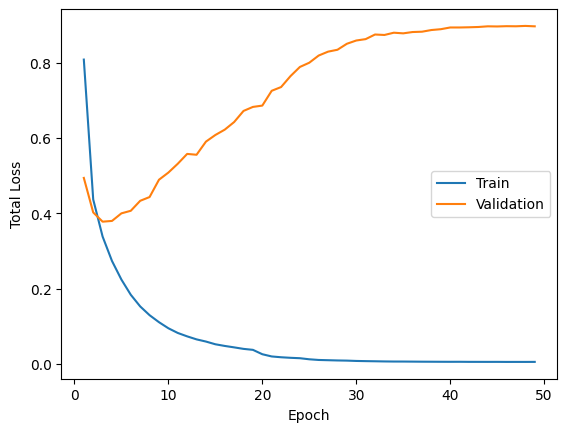

In [42]:
plt.plot(epochs, train_loss, label="Train")
plt.plot(epochs, val_loss, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.legend()

plt.show()

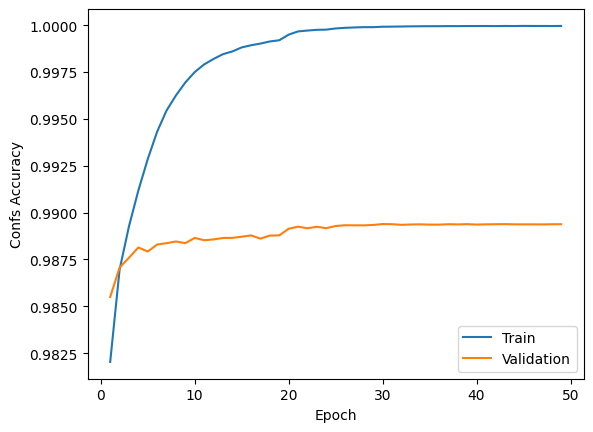

In [43]:
plt.plot(epochs, train_confs_acc, label="Train")
plt.plot(epochs, val_confs_acc, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Confs Accuracy")
plt.legend()

plt.show()

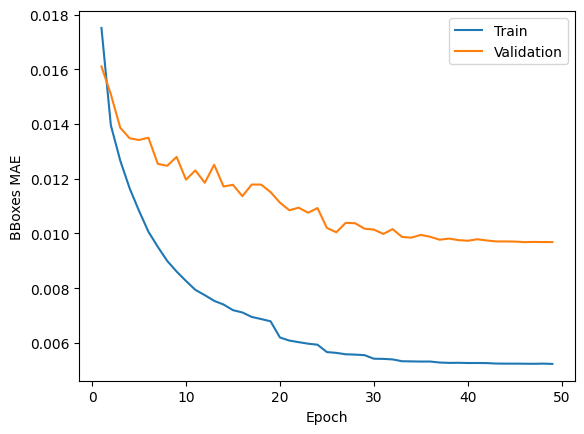

In [44]:
plt.plot(epochs, train_bboxes_mae, label="Train")
plt.plot(epochs, val_bboxes_mae, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("BBoxes MAE")
plt.legend()

plt.show()

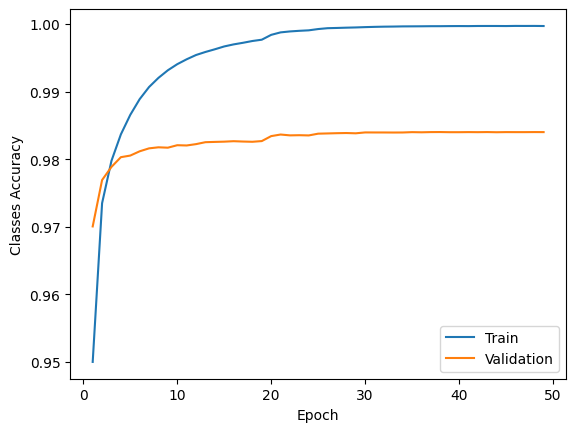

In [45]:
plt.plot(epochs, train_classes_acc, label="Train")
plt.plot(epochs, val_classes_acc, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Classes Accuracy")
plt.legend()

plt.show()

## Predicting by the Model

In [46]:
model = models.load_model(model_path, custom_objects={"OCRModel": OCRModel})

1/1 [==============================] - 0s 40ms/step
Confidence Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Found Classes: [6, 0, 9, 1, 3, 8, 9, 9, 8, 2, 3, 2, 9, 7]
Found Objects #: 14

Card Type: <IPython.core.display.Image object>
CVV2: <IPython.core.display.Image object>
Expiration Date: <IPython.core.display.Image object>


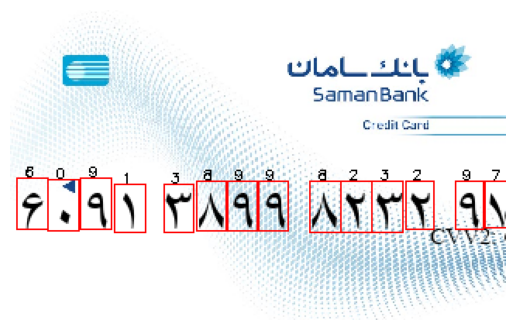

In [50]:
predict_and_show("./dataset/trainset/images/"+x_train[10])

1/1 [==============================] - 0s 32ms/step
Confidence Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Found Classes: [0, 8, 3, 8, 4, 2, 8, 4, 1, 0, 0, 1, 7, 3, 9, 7]
Found Objects #: 16

Card Type: <IPython.core.display.Image object>
CVV2: <IPython.core.display.Image object>
Expiration Date: <IPython.core.display.Image object>


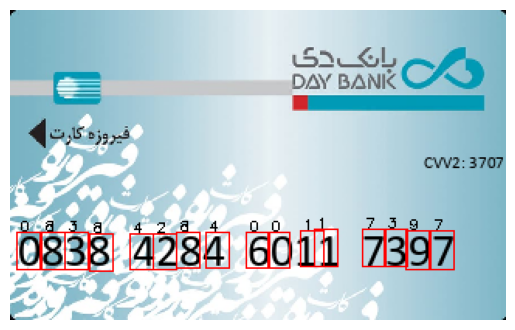

In [51]:
predict_and_show("./dataset/trainset/images/"+x_val[150])

1/1 [==============================] - 0s 34ms/step
Confidence Scores: [1.0, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Found Classes: [0, 0, 5, 0, 3, 0, 5, 0, 6, 0, 4, 6]
Found Objects #: 12

Card Type: <IPython.core.display.Image object>
CVV2: <IPython.core.display.Image object>
Expiration Date: <IPython.core.display.Image object>


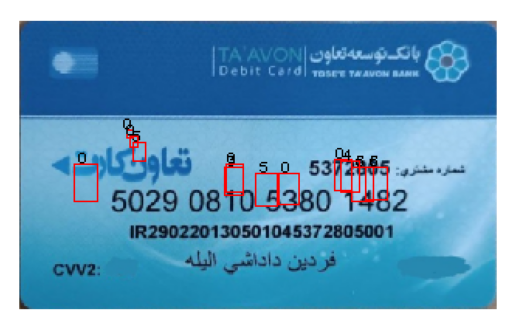

In [52]:
predict_and_show("./dataset/testset/0.png")